# Notebook for the first baseline model - predictions per cell  
Starting with PCA embeddings of RNA, using Linear Regression to predict how a clone responses to vaccination in a late time point, using data from P1 (initial time point) to predcit S1 and T1


In [84]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [85]:
import pandas as pd
import numpy as np
import scirpy as ir
import anndata as ad
import scanpy as sc
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import moscot
from sklearn.metrics import mean_squared_error, r2_score

## Get data & explore data

In [86]:
adata = sc.read_h5ad('/Users/juliakuhn/Desktop/uni/WS2425/cmscb/Project_phase/VaccineSimulator_old/02_dex_annotated_cd8.h5ad')
adata

AnnData object with n_obs × n_vars = 53907 × 18471
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'LTDEMIAQY', 'YTN

In [87]:
adata.obs

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,clr_Isotype_RTK2758,clr_Isotype_RTK4530,clr_CCR7,clr_CD62L,clr_CXCR3,clr_CD45RA,log_clone_size,TCR_mean,TCRC_mean,is_dex+
AAACCTGAGTGTTGAA-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC1,NaN,396.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.065794,1.511381,False
AAACCTGCACCAGGCT-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC1,NaN,6164.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.088723,1.310205,False
AAACCTGCATACGCTA-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC2,NaN,5506.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.484907,0.091682,0.705496,False
AAACGGGAGATGTGGC-1-initial-0-0,True,True,False,[],TRAC,NaN,NaN,NaN,4264.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062257,0.914930,False
AAACGGGGTACGAAAT-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC2,NaN,680.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.828641,0.064372,1.095210,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCTCTCTGAGA-1-2-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,3450.0,NaN,...,NaN,NaN,0.54596,0.0,0.000000,0.531053,0.000000,0.081136,1.335303,False
TTTGGTTGTTCGGGCT-1-2-1,True,True,False,[],TRAC,NaN,TRBC2,NaN,892.0,NaN,...,NaN,NaN,0.54596,0.0,0.197889,0.287940,1.609438,0.078837,1.086240,False
TTTGGTTTCCACGACG-1-2-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,1186.0,NaN,...,NaN,NaN,0.00000,0.0,0.000000,0.360315,6.993933,0.084793,2.290340,False
TTTGTCACAGCTGCAC-1-2-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,884.0,NaN,...,NaN,NaN,0.00000,0.0,0.000000,0.569542,6.993933,0.065752,1.288824,False


In [88]:
adata.var

,gene_ids,feature_types-0,genome-0,n_cells-0,feature_types-1,genome-1,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,27,Gene Expression,GRCh38,False,0.000874,1.075864,-1.150517
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,441,Gene Expression,GRCh38,False,0.023432,1.259884,-0.108835
LINC01409,ENSG00000237491,Gene Expression,GRCh38,358,Gene Expression,GRCh38,False,0.020166,1.242911,-0.204914
FAM87B,ENSG00000177757,Gene Expression,GRCh38,71,Gene Expression,GRCh38,False,0.003413,1.224581,-0.308672
LINC01128,ENSG00000228794,Gene Expression,GRCh38,1677,Gene Expression,GRCh38,False,0.097386,1.220801,-0.330072
...,...,...,...,...,...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,124,Gene Expression,GRCh38,True,0.006435,1.310383,0.177024
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,490,Gene Expression,GRCh38,False,0.022972,1.222385,-0.321103
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,378,Gene Expression,GRCh38,False,0.020251,1.274951,-0.023547
AC004556.3,ENSG00000276345,Gene Expression,GRCh38,274,Gene Expression,GRCh38,False,0.024502,1.221166,-0.328006


In [89]:
print(adata.obs.donor.cat.categories.values)
print(adata.obs.time.cat.categories.values)
adata.obs[['donor','time','experiment']].head(3)

['A02' 'A03' 'A04' 'A05' 'A06' 'A07' 'A08' 'A11' 'A15' 'A16' 'A19' 'A25'
 'A29' 'HIM']
['P1' 'S1' 'S2' 'S3' 'T1' 'T2' 'T3' 'X3' 'extra']


,donor,time,experiment
AAACCTGAGTGTTGAA-1-initial-0-0,A15,S2,first_experiment
AAACCTGCACCAGGCT-1-initial-0-0,A29,S2,first_experiment
AAACCTGCATACGCTA-1-initial-0-0,A15,S2,first_experiment


# Creat RNA Embeddings with PCA
Here, the sc.tl.pca was utlized, with manually selecting the number of principal components with the use of a variance ratio plot. Alternatively, one could use sklearn.PCA  
PCA embeddings are saved automatically in adata.obsm["X_pca"]

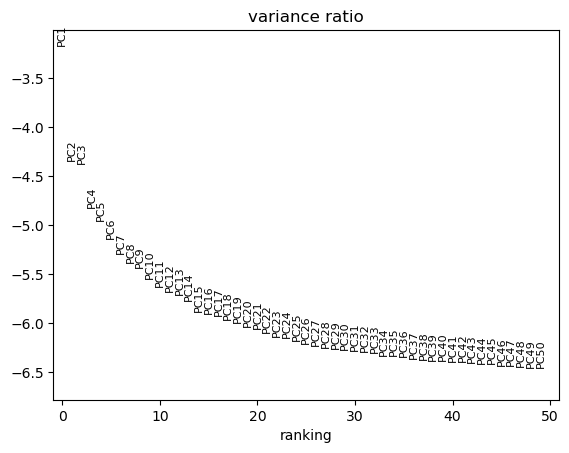

In [90]:
pca_adata = adata.copy()
sc.tl.pca(pca_adata)
sc.pl.pca_variance_ratio(pca_adata, log=True, n_pcs=50) # Elbow plot

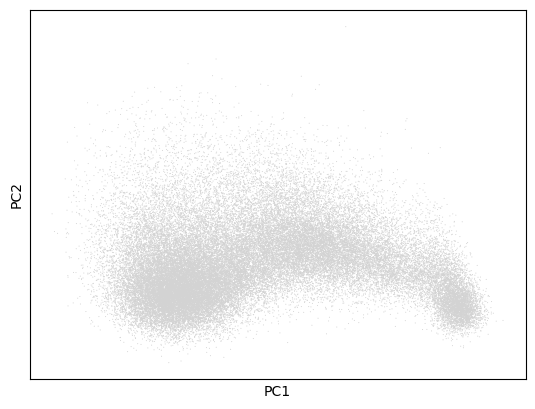

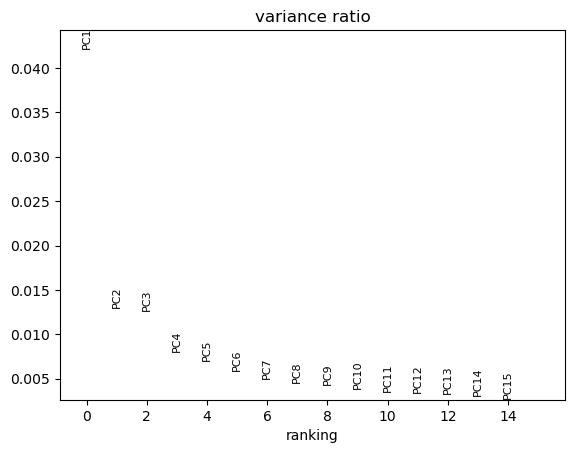

In [91]:
sc.tl.pca(adata, n_comps=15) # Perform PCA -> use 15 components since they explain 90% of the variance (plot)
sc.pl.pca(adata) # Plot only the top two principal components as they are most informative
sc.pl.pca_variance_ratio(adata, n_pcs=15) 

In [92]:
adata.obsm["X_pca"] # check if PCA was stored in adata

array([[ 7.353587  ,  2.29312   ,  5.4750752 , ..., -0.42035687,
        -0.49187803, -0.7464356 ],
       [ 8.43855   , -4.256904  ,  2.3050916 , ...,  2.3662107 ,
         0.5867158 , -0.10706465],
       [-3.9699323 ,  9.784482  ,  1.7513833 , ...,  2.0638516 ,
         2.7388659 , -2.1803946 ],
       ...,
       [-4.581493  , -1.3408741 ,  1.0974848 , ..., -1.1644561 ,
        -1.8378513 , -0.4381631 ],
       [-3.700599  , -1.7343316 , -1.1275474 , ..., -1.7393212 ,
         0.7136927 ,  0.39432332],
       [-2.0187397 ,  1.9200503 , -4.7965045 , ...,  0.93349403,
         0.4397695 ,  0.09894234]], dtype=float32)

In [93]:
sc.pp.neighbors(adata, n_pcs=15, n_neighbors=15) # Compute the neighborhood graph
sc.tl.umap(adata) # Perform UMAP # TODO brauche ich das?????

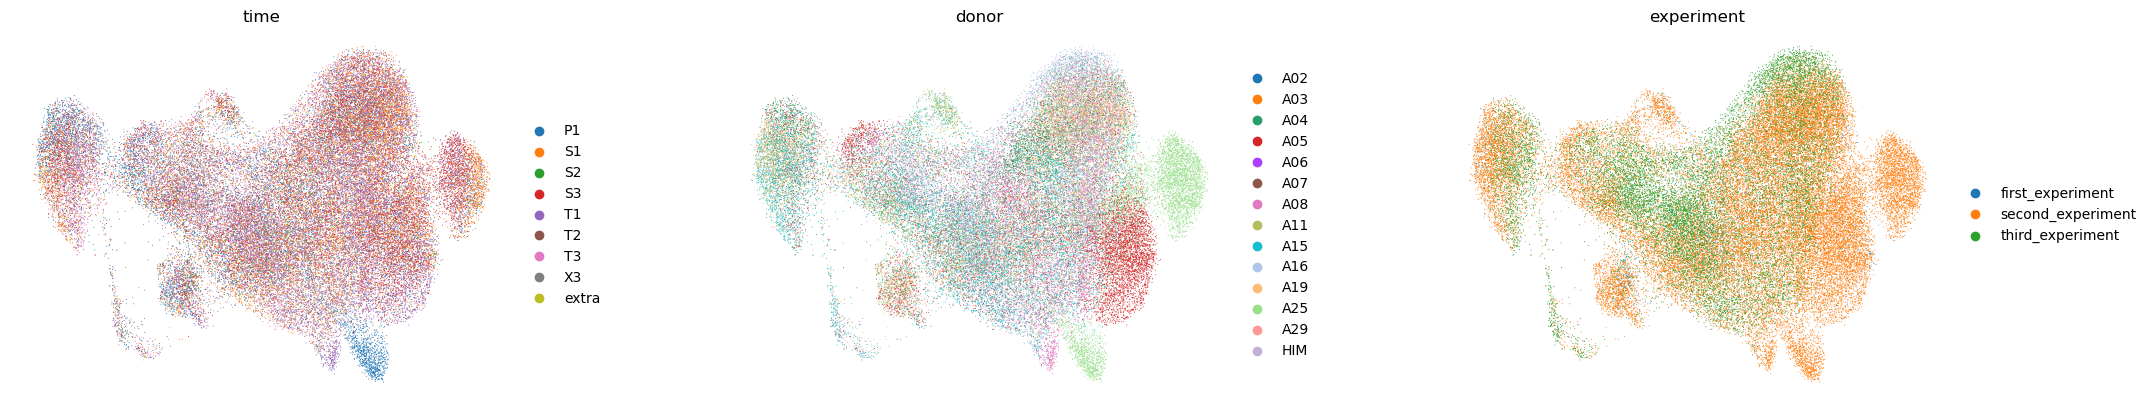

In [94]:
sc.pl.umap(adata, color=['time','donor','experiment'], frameon=False, wspace=0.3, size=2)

# Clone Aggregation and Pairing:
For each clone early and late time point data is paired.
Not all clones in P1 might exist in S1 or T1. Here, we ensure that only clones with valid response scores are included in the model training.

In [95]:
# filter out cells that we can't use
adata = adata[~adata.obs.clone_id.isna()]
adata = adata[~(adata.obs.clone_id=='nan')]
adata = adata[~(adata.obs.time.isin(['X3','extra']))]

In [96]:
# Filter for time points
P1_mask = adata.obs["time"] == "P1"
S1_mask = adata.obs["time"] == "S1"
T1_mask = adata.obs["time"] == "T1"

# Features: Embeddings from P1
X = adata[P1_mask].obsm["X_pca"]

"""#get target variable and clones from S1 and T1
S1_clones = adata[S1_mask].obs["clone_id"].values  # Clonotypes at S1
S1_targets = adata[S1_mask].obs["IFN Response_score"].values # target variable

T1_clones = adata[T1_mask].obs["clone_id"].values  # Clonotypes at T1
T1_targets = adata[T1_mask].obs["IFN Response_score"].values # target variable
print(T1_targets.shape)

P1_clones = adata[P1_mask].obs["clone_id"].values
P1_targets = adata[P1_mask].obs["IFN Response_score"].values """

'#get target variable and clones from S1 and T1\nS1_clones = adata[S1_mask].obs["clone_id"].values  # Clonotypes at S1\nS1_targets = adata[S1_mask].obs["IFN Response_score"].values # target variable\n\nT1_clones = adata[T1_mask].obs["clone_id"].values  # Clonotypes at T1\nT1_targets = adata[T1_mask].obs["IFN Response_score"].values # target variable\nprint(T1_targets.shape)\n\nP1_clones = adata[P1_mask].obs["clone_id"].values\nP1_targets = adata[P1_mask].obs["IFN Response_score"].values '

In [97]:
# Step 1: Identify responsive Leiden clusters
responsive_clusters = [6, 8]  # Define known responsive clusters

# Step 2: Get Leiden clusters for each time point
S1_leiden = adata[S1_mask].obs["leiden_CD8"].astype(int).values  # Leiden clusters for S1
T1_leiden = adata[T1_mask].obs["leiden_CD8"].astype(int).values  # Leiden clusters for T1
P1_leiden = adata[P1_mask].obs["leiden_CD8"].astype(int).values  # Leiden clusters for P1

# Step 3: Convert to binary labels (1 = responsive, 0 = non-responsive)
S1_targets = np.isin(S1_leiden, responsive_clusters).astype(int)  # Binary target for S1
T1_targets = np.isin(T1_leiden, responsive_clusters).astype(int)  # Binary target for T1
P1_targets = np.isin(P1_leiden, responsive_clusters).astype(int)  # Binary target for P1

# Step 4: mapping to P1_clones
S1_clones = adata[S1_mask].obs["clone_id"].values  # Clonotypes at S1
T1_clones = adata[T1_mask].obs["clone_id"].values  # Clonotypes at T1
P1_clones = adata[P1_mask].obs["clone_id"].values  # Clonotypes at P1
print(T1_targets.shape)


(8495,)


# Cell Pairing

## Model with Cell Pairing based on timepoints

In [102]:
# Map S1 and T1 responses to corresponding P1 clones to ensure that only clones with corresponding targets are included
# s1 = np.array([S1_targets[np.where(S1_clones == cid)[0][0]] if cid in S1_clones else np.nan for cid in P1_clones])
# t1 = np.array([T1_targets[np.where(T1_clones == cid)[0][0]] if cid in T1_clones else np.nan for cid in P1_clones])

s1 = np.array([np.random.choice(S1_targets[np.where(S1_clones == cid)[0]], size=1)[0] 
               if cid in S1_clones else np.nan for cid in P1_clones])

t1 = np.array([np.random.choice(T1_targets[np.where(T1_clones == cid)[0]], size=1)[0] 
               if cid in T1_clones else np.nan for cid in P1_clones])


# Remove clones without corresponding targets
valid_indices =  ~np.isnan(s1) & ~np.isnan(t1)

X, s1, t1 = X[valid_indices], s1[valid_indices], t1[valid_indices]
P1_clones = P1_clones[valid_indices]

In [103]:
# get cells per clonotype
clonotype_cell_counts = pd.DataFrame(P1_clones, columns=["Clonotype"]).value_counts().reset_index()
clonotype_cell_counts.columns = ["Clonotype", "Cell Count"]

# Display the counts per clonotype
clonotype_cell_counts

,Clonotype,Cell Count
0,897.0,297
1,926.0,216
2,30.0,160
3,870.0,141
4,171.0,136
...,...,...
3605,2551.0,0
3606,2552.0,0
3607,2553.0,0
3608,2555.0,0


In [104]:
adata.obs["clone_id"].value_counts()

clone_id
897.0      2388
30.0       1124
926.0      1090
171.0       995
855.0       747
           ... 
6607.0        1
6608.0        1
6610.0        1
6611.0        1
20300.0       1
Name: count, Length: 12701, dtype: int64

## Split into Train-Val-Test

 The splitting is done based on the unique clonotypes (unique_clonotypes_aggregated) to ensure that clones seen in the training set are not present in the test set. Here, a 80-20 split is used.

 Possible options to avoid biases:
 - split to maintain the distribution of responses in both train and test sets
 - additionally divide based on donor or experiment


### Split by Timepoint

In [106]:
from sklearn.model_selection import train_test_split
# Step 1: Keep cell-level data without aggregation
X_cells = X  # Features for individual cells
y_s1_cells = s1  # Target values for S1 at the cell level
y_t1_cells = t1  # Target values for T1 at the cell level

# Step 2: Split clonotypes into train, test, and eval sets
unique_clonotypes = np.unique(P1_clones)  # Unique clonotypes

# First, split clonotypes into train and temp (for test and eval splitting)
train_clonotypes, temp_clonotypes = train_test_split(unique_clonotypes, test_size=0.3, random_state=42)

# Then split temp_clonotypes into test and eval (50% each)
test_clonotypes, eval_clonotypes = train_test_split(temp_clonotypes, test_size=0.5, random_state=42)

# Step 3: Create masks for selecting individual cells belonging to the train/test/eval clonotypes
train_mask = np.isin(P1_clones, train_clonotypes)  # Select cells with train clonotypes
test_mask = np.isin(P1_clones, test_clonotypes)    # Select cells with test clonotypes
eval_mask = np.isin(P1_clones, eval_clonotypes)    # Select cells with eval clonotypes

# Step 4: Apply these masks to get cell-level training and testing data
X_train, X_test = X_cells[train_mask], X_cells[test_mask]
y_s1_train, y_s1_test = y_s1_cells[train_mask], y_s1_cells[test_mask]
y_t1_train, y_t1_test = y_t1_cells[train_mask], y_t1_cells[test_mask]

# Now X_train and y_s1_train contain individual cells instead of aggregated values
print("Train Shape:", X_train.shape, y_s1_train.shape)
print("Test Shape:", X_test.shape, y_s1_test.shape)


Train Shape: (3147, 15) (3147,)
Test Shape: (477, 15) (477,)


In [107]:
import smogn

# Define feature names for creating DataFrames
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

In [108]:
k_smogn = 5
samp_method_smogn = 'balance'
rel_thres_smogn = 0.6

rg_mtrx = [
    [0.0, 0, 0],    # At score 0.0, relevance is 0 (not minority)
    [0.45, 0, 0],   # Up to 0.59, relevance stays 0
    [0.4501, 1, 0],    # At 0.6, relevance jumps to 1 (minority)
    [3, 1, 0]     # Up to 1.0, relevance remains 1
]

In [ ]:
### --- For S1 Predictions ---

# Create DataFrame for S1 data
df_s1 = pd.DataFrame(X_train, columns=feature_names)
df_s1['target'] = y_s1_train
df_s1 = df_s1.dropna()

# Apply SMOGN oversampling for regression on S1 data.
# Adjust the parameters (e.g., rel_thres) based on your data distribution.
df_s1_resampled = smogn.smoter(
    data=df_s1,
    y='target',
    k=k_smogn,
    samp_method=samp_method_smogn,  # oversample the extreme target values
    rel_thres=rel_thres_smogn,          # relevance threshold (tune this parameter)
    rel_method='manual',      # let SMOGN automatically compute relevance scores
    drop_na_row=True,
    rel_ctrl_pts_rg = rg_mtrx
)

# Separate features and target for S1
X_s1_resampled = df_s1_resampled.drop(columns=['target']).values
y_s1_resampled = df_s1_resampled['target'].values

r_index: 100%|##########| 4/4 [00:00<00:00, 780.48it/s]


In [ ]:
X_train_s1 = X_s1_resampled
y_s1_train = y_s1_resampled

In [128]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_s1_train)
y_s1_pred_lr = lr.predict(X_test)

lr.fit(X_train, y_t1_train)
y_t1_pred_lr = lr.predict(X_test)

print("Accuracy LR:", accuracy_score(y_s1_test, y_s1_pred_lr))
print("Accuracy LR:", accuracy_score(y_t1_test, y_t1_pred_lr))

# Step 6: Train a classifier (e.g., Gradient Boosting, but could also use RF or LR)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, )
clf.fit(X_train, y_s1_train)  # Train on binary response

# Step 7: Make predictions
y_s1_pred_gb = clf.predict(X_test)

clf.fit(X_train, y_t1_train)  # Train on binary
y_t1_pred_gb = clf.predict(X_test)

# Step 8: Evaluate
print("Accuracy GB:", accuracy_score(y_s1_test, y_s1_pred_gb))
print("Accuracy GB:", accuracy_score(y_t1_test, y_t1_pred_gb)) 


# random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_s1_train)
y_s1_pred_rf = rf.predict(X_test)

rf.fit(X_train, y_t1_train)
y_t1_pred_rf = rf.predict(X_test)

print("Accuracy RF:", accuracy_score(y_s1_test, y_s1_pred_rf))
print("Accuracy RF:", accuracy_score(y_t1_test, y_t1_pred_rf))


Accuracy LR: 0.9664570230607966
Accuracy LR: 0.9161425576519916
Accuracy GB: 0.9643605870020965
Accuracy GB: 0.9140461215932913
Accuracy RF: 0.9664570230607966
Accuracy RF: 0.9224318658280922


In [110]:
# Aggregate predictions per clonotype (mean per clonotype)
unique_test_clonotypes = np.unique(P1_clones[test_mask])
y_s1_pred_clonotype = []
y_s1_true_clonotype = []

for clone in unique_test_clonotypes:
    mask = P1_clones[test_mask] == clone  # Select all cells in the same clonotype
    if np.sum(mask) > 0:
        y_s1_pred_clonotype.append(np.mean(y_s1_pred_gb[mask]))  # Mean prediction for clonotype
        y_s1_true_clonotype.append(np.mean(y_s1_test[mask]))  # Mean true response for clonotype

# Convert lists to numpy arrays
y_s1_pred_clonotype = np.array(y_s1_pred_clonotype)
y_s1_true_clonotype = np.array(y_s1_true_clonotype)

# Step 3: Compute MSE at the clonotype level
mse_clonotype = mean_squared_error(y_s1_true_clonotype, y_s1_pred_clonotype)

# Print Results
print("Cell-Level MSE:", mean_squared_error(y_s1_test, y_s1_pred_gb))
print("Clonotype-Level MSE:", mse_clonotype)


Cell-Level MSE: 0.03563941299790356
Clonotype-Level MSE: 0.025167243405526857


In [111]:
from collections import Counter
from sklearn.metrics import accuracy_score

# Step 1: Initialize lists for storing clonotype-level predictions
y_s1_pred_clonotype = []
y_s1_true_clonotype = []

# Step 2: Aggregate per clonotype using majority vote
for clone in unique_test_clonotypes:
    mask = P1_clones[test_mask] == clone  # Select all cells in the same clonotype
    
    if np.sum(mask) > 0:
        # Majority vote: most common class in predicted labels
        most_common_pred = Counter(y_s1_pred_gb[mask]).most_common(1)[0][0]
        most_common_true = Counter(y_s1_test[mask]).most_common(1)[0][0]

        y_s1_pred_clonotype.append(most_common_pred)
        y_s1_true_clonotype.append(most_common_true)

# Convert lists to numpy arrays
y_s1_pred_clonotype = np.array(y_s1_pred_clonotype)
y_s1_true_clonotype = np.array(y_s1_true_clonotype)

# Step 3: Compute Accuracy at Clonotype Level
accuracy_clonotype = accuracy_score(y_s1_true_clonotype, y_s1_pred_clonotype)

# Print Results
print("Cell-Level Accuracy:", accuracy_score(y_s1_test, y_s1_pred_gb))
print("Clonotype-Level Accuracy:", accuracy_clonotype)


Cell-Level Accuracy: 0.9643605870020965
Clonotype-Level Accuracy: 0.9565217391304348


In [112]:
import numpy as np

# Compute baseline accuracy (predicting all cells as non-responsive = 0)
num_nonresponsive_S1 = np.sum(S1_targets == 0)
num_responsive_S1 = np.sum(S1_targets == 1)
baseline_accuracy_S1 = num_nonresponsive_S1 / (num_nonresponsive_S1 + num_responsive_S1)

num_nonresponsive_T1 = np.sum(T1_targets == 0)
num_responsive_T1 = np.sum(T1_targets == 1)
baseline_accuracy_T1 = num_nonresponsive_T1 / (num_nonresponsive_T1 + num_responsive_T1)

print(f"Baseline Accuracy for S1: {baseline_accuracy_S1:.2f}")
print(f"Baseline Accuracy for T1: {baseline_accuracy_T1:.2f}")


Baseline Accuracy for S1: 0.93
Baseline Accuracy for T1: 0.88


In [ ]:
# Compute your model's accuracy
model_accuracy = accuracy_score(y_s1_test, y_s1_pred_gb)

print(f"📊 Model Accuracy: {model_accuracy:.4f}")


📊 Model Accuracy: 0.9644


# Evaluate Predictions
Calculated mse, recall at k, mean on the activated clonotypes to evaluate the correctness of the predictions

In [116]:
import numpy as np

def recall_at_k(y_true, y_pred, k):
    # Get the indices of the top-k predicted scores
    top_k_pred_indices = np.argsort(y_pred)[-k:]  # Indices of top-k predicted scores
    # Get the indices of the top-k true scores
    top_k_true_indices = np.argsort(y_true)[-k:]  # Indices of top-k true scores

    # Compute intersection of predicted and true top-k indices
    intersection = np.intersect1d(top_k_pred_indices, top_k_true_indices)

    # Compute Recall@k
    recall_k = len(intersection) / k
    return recall_k


In [117]:
def aggregate_predictions_by_clonotype(y_pred):
    """
    Aggregate responses by clonotype.

    Args:
        y_pred (array-like): Responses (predicted) for each cell.

    Returns:
        dict: A dictionary mapping each clonotype to its predicted responses.
    """
    test_clonotype_labels = unique_clonotypes_aggregated[test_mask]  # Get the clonotype labels for the test set


    # Create an empty dictionary to store predictions for each clonotype
    predictions_by_clonotype = {}

    # Iterate over each unique clonotype in the test set
    for clonotype in np.unique(test_clonotype_labels):
        # Get indices of the test samples corresponding to this clonotype
        clonotype_mask = test_clonotype_labels == clonotype

        # Get the predicted values for this clonotype
        clonotype_predictions = y_pred[clonotype_mask]

        # Store these predictions in the dictionary
        predictions_by_clonotype[clonotype] = clonotype_predictions

    return predictions_by_clonotype

In [118]:
def recall_at_k_clonotype(y_true, y_pred, k):
    """
    Compute recall at K based on clonotype-level responsiveness.

    Args:
        y_true (array-like): True responses for each cell.
        y_pred (array-like): Predicted responses for each cell.
        k (int): Number of top clonotypes to consider.

    Returns:
        float: Recall at K based on clonotypes.

        
    """
    
    # Aggregate responses by clonotype
    true_responses_by_clonotype = aggregate_predictions_by_clonotype(y_true)
    pred_responses_by_clonotype = aggregate_predictions_by_clonotype(y_pred)

    # Sort clonotypes by their average true and predicted responses -> # TODO why? 
    top_k_true_clonotypes = sorted(
        true_responses_by_clonotype, key=true_responses_by_clonotype.get, reverse=True
    )[:k]
    top_k_pred_clonotypes = sorted(
        pred_responses_by_clonotype, key=pred_responses_by_clonotype.get, reverse=True
    )[:k]

    # Compute the intersection of top-k true and predicted clonotypes
    intersection = set(top_k_true_clonotypes) & set(top_k_pred_clonotypes)

    # Compute Recall@K
    recall_k = len(intersection) / k
    return recall_k

In [119]:
def mse_clonotype(y_pred, y_true):
    """
    Aggregate responses by clonotype and calculate MSE per clonotype.

    Args:
        y_pred (array-like): Predicted responses for each cell.
        y_true (array-like): True responses for each cell.

    Returns:
        dict: A dictionary mapping each clonotype to its predicted responses and MSE.
        float: The mean MSE across all clonotypes.
    """

    # Get the clonotype labels for the test set (assumed to be pre-defined)
    test_clonotype_labels = unique_clonotypes_aggregated[test_mask]  # Make sure test_mask is defined
     
    # Create an empty dictionary to store predictions and MSE for each clonotype
    predictions_by_clonotype = {}
    mse_by_clonotype = {}

    # Iterate over each unique clonotype in the test set
    for clonotype in np.unique(test_clonotype_labels):
        # Get indices of the test samples corresponding to this clonotype
        clonotype_mask = test_clonotype_labels == clonotype

        # Get the predicted values and true values for this clonotype
        clonotype_predictions = y_pred[clonotype_mask]
        clonotype_true_values = y_true[clonotype_mask]

        # Calculate the MSE for this clonotype
        mse = mean_squared_error(clonotype_true_values, clonotype_predictions)

        # Store predictions and MSE in the dictionary
        predictions_by_clonotype[clonotype] = clonotype_predictions
        mse_by_clonotype[clonotype] = mse

    # Calculate the mean MSE across all clonotypes
    mean_mse = np.mean(list(mse_by_clonotype.values()))

    return mse_by_clonotype, mean_mse


In [120]:
k = 5

# Evaluate S1 predictions
mse_s1 = mean_squared_error(y_s1_test, y_s1_pred)
mse_s1_clonotype, mse_s1_mean = mse_clonotype(y_s1_test, y_s1_pred)

recall_ks1 = recall_at_k_clonotype(
    y_s1_test,
    y_s1_pred,
    k
)
mean_clonotype_activation_s1_predicted = y_s1_pred.mean()  # Predicted mean clonotype activation for the test set
mean_clonotype_activation_s1 = y_s1_test.mean()# True mean clonotype activation for the test set

print(f"Recall@{k} for S1: {recall_ks1:.2f}")
print(f"MSE- Mean for S1: {mse_s1_mean}")
print(f"Mean Clonotype Activation (S1): {mean_clonotype_activation_s1:.4f}")
print(f"Mean Clonotype Activation (S1) Predicted: {mean_clonotype_activation_s1_predicted:.4f}")



# Evaluate T1 predictions
mse_t1 = mean_squared_error(y_t1_test, y_t1_pred)
mse_t1_clonotype, mse_t1_mean = mse_clonotype(y_t1_test, y_t1_pred)
recall_kt1 = recall_at_k_clonotype(
    y_t1_test,
    y_t1_pred,
    k
)
mean_clonotype_activation_t1 = y_t1_test.mean()
mean_clonotype_activation_t1_predicted = y_t1_pred.mean()

print(f"Recall@{k} for T1: {recall_kt1:.2f}")
print(f"MSE- Mean for T1: {mse_t1_mean}")
print(f"Mean Clonotype Activation (T1): {mean_clonotype_activation_t1:.4f}")
print(f"Mean Clonotype Activation (T1) Predicted: {mean_clonotype_activation_t1_predicted:.4f}")


NameError: name 'y_s1_pred' is not defined

In [ ]:
# --- Quartile MSE Analysis for S1 ---
# Sort clones by true response level
sorted_indices_s1 = np.argsort(y_s1_test)

# Get quartile indices
q1_s1 = sorted_indices_s1[: len(sorted_indices_s1) // 4]  # Bottom 25% (low responders)
q4_s1 = sorted_indices_s1[-len(sorted_indices_s1) // 4:]  # Top 25% (high responders)

# Compute MSE for the two quartiles
mse_s1_low = mean_squared_error(y_s1_test[q1_s1], y_s1_pred_gb[q1_s1])
mse_s1_high = mean_squared_error(y_s1_test[q4_s1], y_s1_pred_gb[q4_s1])

print(f"MSE for bottom 25% (low-responding clones) in S1: {mse_s1_low:.4f}")
print(f"MSE for top 25% (high-responding clones) in S1: {mse_s1_high:.4f}")

MSE for bottom 25% (low-responding clones) in S1: 0.1261
MSE for top 25% (high-responding clones) in S1: 0.1333


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

k = 5  # Recall@k setting

# --- Standard Evaluation ---
# Evaluate S1 predictions
mse_s1 = mean_squared_error(y_s1_test, y_s1_pred_gb)
mse_s1_clonotype, mse_s1_mean = mse_clonotype(y_s1_test, y_s1_pred_gb)
recall_ks1 = recall_at_k_clonotype(y_s1_test, y_s1_pred_gb, k)

mean_clonotype_activation_s1_predicted = y_s1_pred_gb.mean()
mean_clonotype_activation_s1 = y_s1_test.mean()

print(f"Recall@{k} for S1: {recall_ks1:.2f}")
print(f"MSE- Mean for S1: {mse_s1}")
print(f"MSE- Clonotype mean for S1: {mse_s1_mean}")
print(f"Mean Clonotype Activation (S1): {mean_clonotype_activation_s1:.4f}")
print(f"Mean Clonotype Activation (S1) Predicted: {mean_clonotype_activation_s1_predicted:.4f}")

# --- Quartile MSE Analysis for S1 ---
# Sort clones by true response level
sorted_indices_s1 = np.argsort(y_s1_test)

# Get quartile indices
q1_s1 = sorted_indices_s1[: len(sorted_indices_s1) // 4]  # Bottom 25% (low responders)
q4_s1 = sorted_indices_s1[-len(sorted_indices_s1) // 4:]  # Top 25% (high responders)

# Compute MSE for the two quartiles
mse_s1_low = mean_squared_error(y_s1_test[q1_s1], y_s1_pred_gb[q1_s1])
mse_s1_high = mean_squared_error(y_s1_test[q4_s1], y_s1_pred_gb[q4_s1])

print(f"MSE for bottom 25% (low-responding clones) in S1: {mse_s1_low:.4f}")
print(f"MSE for top 25% (high-responding clones) in S1: {mse_s1_high:.4f}")

print(q1_s1)
print(q4_s1)

# --- Standard Evaluation for T1 ---
mse_t1 = mean_squared_error(y_t1_test, y_t1_pred_gb)
mse_t1_clonotype, mse_t1_mean = mse_clonotype(y_t1_test, y_t1_pred_gb)
recall_kt1 = recall_at_k_clonotype(y_t1_test, y_t1_pred_gb, k)

mean_clonotype_activation_t1 = y_t1_test.mean()
mean_clonotype_activation_t1_predicted = y_t1_pred.mean()

print(f"Recall@{k} for T1: {recall_kt1:.2f}")
print(f"MSE- Mean for T1: {mse_t1}")
print(f"MSE- Clonotype mean for T1: {mse_t1_mean}")
print(f"Mean Clonotype Activation (T1): {mean_clonotype_activation_t1:.4f}")
print(f"Mean Clonotype Activation (T1) Predicted: {mean_clonotype_activation_t1_predicted:.4f}")

# --- Quartile MSE Analysis for T1 ---
sorted_indices_t1 = np.argsort(y_t1_test)

q1_t1 = sorted_indices_t1[: len(sorted_indices_t1) // 4]  # Bottom 25%
q4_t1 = sorted_indices_t1[-len(sorted_indices_t1) // 4:]  # Top 25%

mse_t1_low = mean_squared_error(y_t1_test[q1_t1], y_t1_pred[q1_t1])
mse_t1_high = mean_squared_error(y_t1_test[q4_t1], y_t1_pred[q4_t1])

print(f"MSE for bottom 25% (low-responding clones) in T1: {mse_t1_low:.4f}")
print(f"MSE for top 25% (high-responding clones) in T1: {mse_t1_high:.4f}")

TypeError: 'numpy.float64' object is not callable

In [ ]:
print(f"MSE for Low Responders (S1): {mse_s1_low:.4f}")
print(f"MSE for High Responders (S1): {mse_s1_high:.4f}")
print(f"MSE for Low Responders (T1): {mse_t1_low:.4f}")
print(f"MSE for High Responders (T1): {mse_t1_high:.4f}")

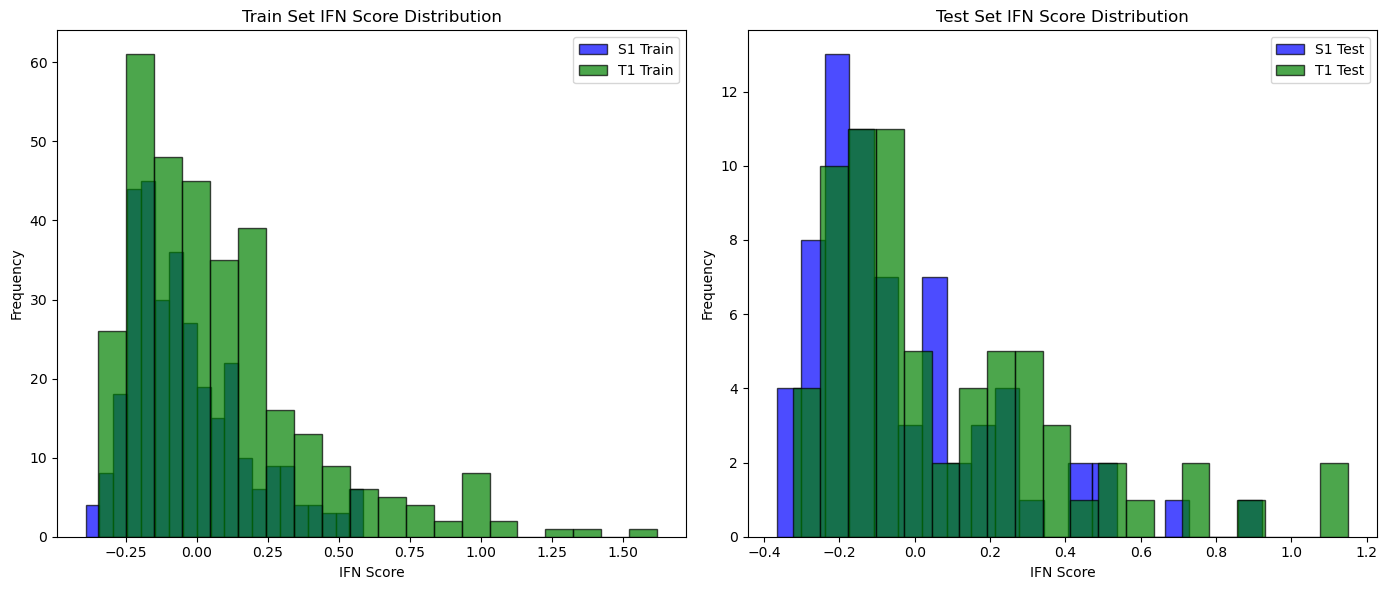

In [ ]:
# plot the IFN score for train and  test subset
import matplotlib.pyplot as plt

# Plot IFN score distributions for train and test sets
plt.figure(figsize=(14, 6))

# Train distribution
plt.subplot(1, 2, 1)
plt.hist(y_s1_train, bins=20, alpha=0.7, label="S1 Train", color="blue", edgecolor="black")
plt.hist(y_t1_train, bins=20, alpha=0.7, label="T1 Train", color="green", edgecolor="black")
plt.title("Train Set IFN Score Distribution")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

# Test distribution
plt.subplot(1, 2, 2)
plt.hist(y_s1_test, bins=20, alpha=0.7, label="S1 Test", color="blue", edgecolor="black")
plt.hist(y_t1_test, bins=20, alpha=0.7, label="T1 Test", color="green", edgecolor="black")
plt.title("Test Set IFN Score Distribution")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

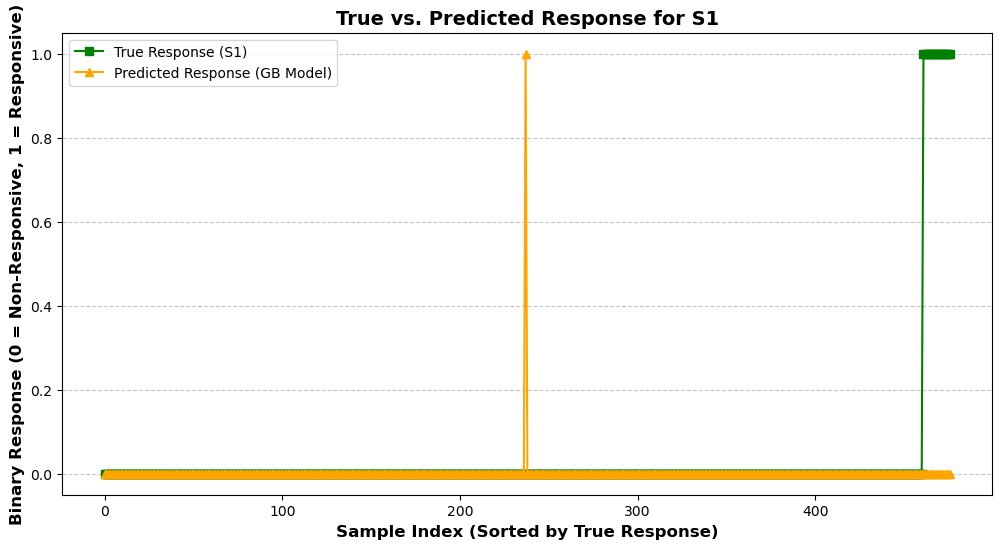

In [125]:
import numpy as np
import matplotlib.pyplot as plt

# Sort the clonotypes based on the true values for better visualization
sorted_indices = np.argsort(y_s1_test)  # Sort by true values

# Apply sorting
y_s1_test_sorted = np.array(y_s1_test)[sorted_indices]
y_s1_pred_sorted = np.array(y_s1_pred_gb)[sorted_indices]

# Create x-axis indices
x = np.arange(len(y_s1_test_sorted))

# Plot true vs. predicted responses
plt.figure(figsize=(12, 6))
plt.plot(x, y_s1_test_sorted, marker="s", linestyle="-", color="green", label="True Response (S1)")
plt.plot(x, y_s1_pred_sorted, marker="^", linestyle="-", color="orange", label="Predicted Response (GB Model)")

# Formatting
plt.xlabel("Sample Index (Sorted by True Response)", fontsize=12, fontweight="bold")
plt.ylabel("Binary Response (0 = Non-Responsive, 1 = Responsive)", fontsize=12, fontweight="bold")
plt.title("True vs. Predicted Response for S1", fontsize=14, fontweight="bold")
plt.legend(loc="upper left", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()



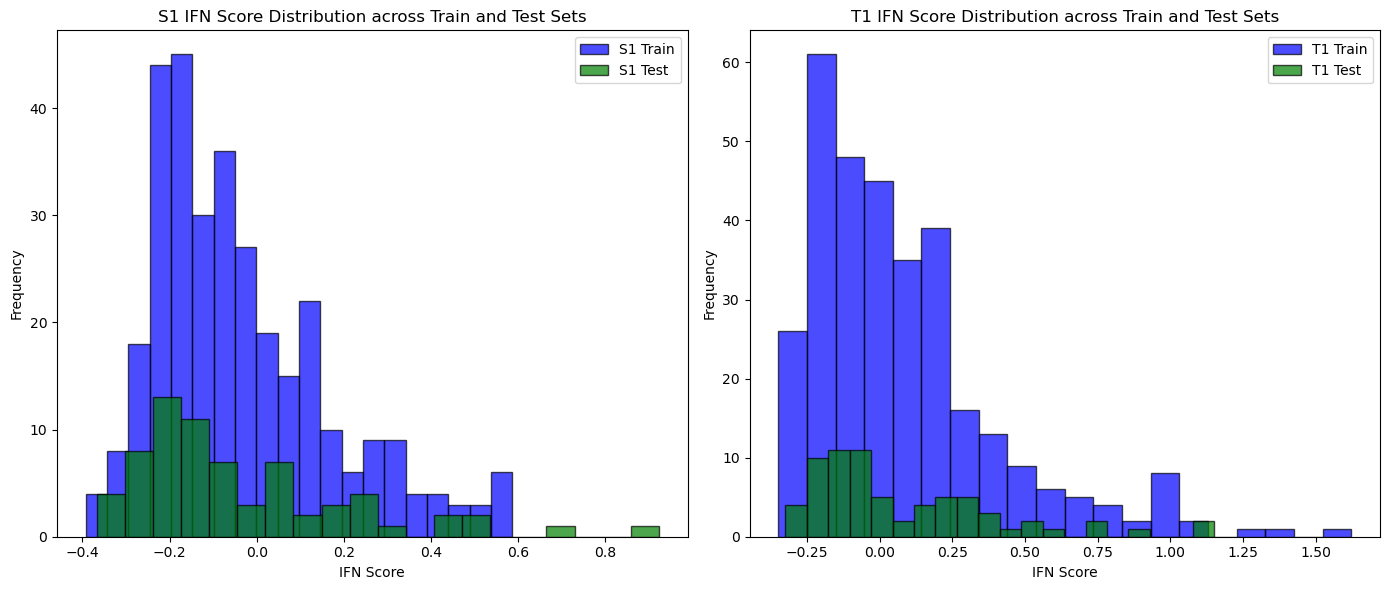

In [ ]:
# plot the IFN score for train and  test subset
import matplotlib.pyplot as plt

# Plot IFN score distributions for train and test sets
plt.figure(figsize=(14, 6))

# Train distribution
plt.subplot(1, 2, 1)
plt.hist(y_s1_train, bins=20, alpha=0.7, label="S1 Train", color="blue", edgecolor="black")
plt.hist(y_s1_test, bins=20, alpha=0.7, label="S1 Test", color="green", edgecolor="black")
plt.title("S1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

# Test distribution
plt.subplot(1, 2, 2)
plt.hist(y_t1_train, bins=20, alpha=0.7, label="T1 Train", color="blue", edgecolor="black")
plt.hist(y_t1_test, bins=20, alpha=0.7, label="T1 Test", color="green", edgecolor="black")
plt.title("T1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

'# T1 distribution\nplt.subplot(1, 2, 2)\nplt.hist(y_t1_train, bins=20, alpha=0.7, label="T1 Train", edgecolor="black")\nplt.hist(y_t1_test, bins=20, alpha=0.7, label="T1 Test", edgecolor="black")\nplt.hist(y_t1_pred, bins=20, alpha=0.7, label="T1 Pred", edgecolor="black")\nplt.axvline(mean_t1_train, color=\'red\', linestyle=\'dashed\', linewidth=2, label=f"T1 Train Mean: {mean_t1_train:.2f}")\nplt.title("T1 IFN Score Distribution across Train and Test Sets")\nplt.xlabel("IFN Score")\nplt.ylabel("Frequency")\nplt.legend()\n\nplt.tight_layout()\nplt.show()'

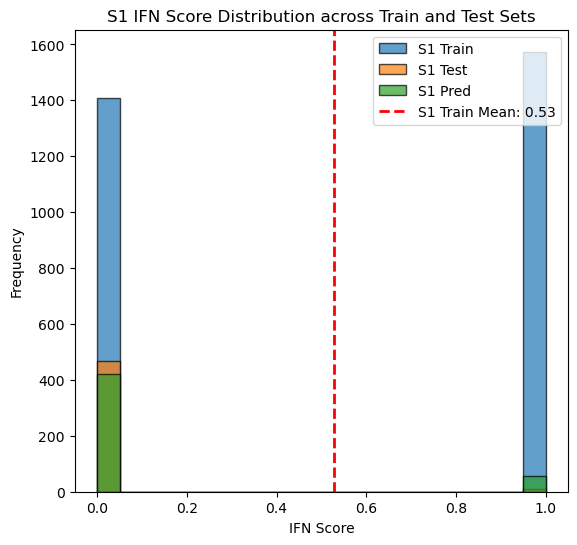

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the means of the distributions
mean_s1_train = np.mean(y_s1_train)

#mean_t1_train = np.mean(y_t1_train)

# Plot IFN score distributions for train and test sets
plt.figure(figsize=(14, 6))

# S1 distribution
plt.subplot(1, 2, 1)
plt.hist(y_s1_train, bins=20, alpha=0.7, label="S1 Train", edgecolor="black")
plt.hist(y_s1_test, bins=20, alpha=0.7, label="S1 Test", edgecolor="black")
plt.hist(y_s1_pred_gb, bins=20, alpha=0.7, label="S1 Pred", edgecolor="black")
plt.axvline(mean_s1_train, color='red', linestyle='dashed', linewidth=2, label=f"S1 Train Mean: {mean_s1_train:.2f}")
plt.title("S1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

"""# T1 distribution
plt.subplot(1, 2, 2)
plt.hist(y_t1_train, bins=20, alpha=0.7, label="T1 Train", edgecolor="black")
plt.hist(y_t1_test, bins=20, alpha=0.7, label="T1 Test", edgecolor="black")
plt.hist(y_t1_pred, bins=20, alpha=0.7, label="T1 Pred", edgecolor="black")
plt.axvline(mean_t1_train, color='red', linestyle='dashed', linewidth=2, label=f"T1 Train Mean: {mean_t1_train:.2f}")
plt.title("T1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()"""


In [ ]:
plt.figure(figsize=(12, 6))

# Plotting true vs predicted S1 for each clonotype (with a color map for MSE)
scatter = plt.scatter(y_s1_test, y_s1_pred, c=mse_values, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='MSE per Clonotype')

plt.xlabel('True S1 Values')
plt.ylabel('Predicted S1 Values')
plt.title('True vs Predicted S1 with MSE Color Map')
plt.tight_layout()
plt.show()

NameError: name 'mse_values' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
# You want to compare the distribution of P1, S1_test, and S1_pred per clonotype

# Plotting the results
clonotypes = [f'Clone {i+1}' for i in range(len(np.unique(test_clonotypes)))]

# Set up the figure
plt.figure(figsize=(12, 6))

# Define the bar width
bar_width = 0.25
index = np.arange(len(clonotypes))

# Plot each of the distributions
plt.bar(index - bar_width, y_p1_test, bar_width, label='P1', color='lightblue')
plt.bar(index, y_s1_test, bar_width, label='S1 Test', color='lightgreen')
plt.bar(index + bar_width, y_s1_pred, bar_width, label='S1 Predicted', color='salmon')

# Add labels, title, and legend
plt.xlabel('Clonotype')
plt.ylabel('Mean Value')
plt.title('Distribution of P1, S1 Test, and S1 Predicted per Clonotype')
plt.xticks(index, clonotypes, rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Explore Results

Focussing on the most active clones 

In [ ]:
# Creating a DataFrame with clone IDs, true scores, and predictions
results_df = pd.DataFrame({
    "Clone_ID": unique_clonotypes_aggregated[test_mask],  # Clonotypes in the test set
    "True_S1_Score": y_s1_test,  # True target values for S1
    "Predicted_S1_Score": model_s1.predict(X_s1_test),  # Predicted values for S1
    "True_T1_Score": y_t1_test,  # True target values for T1
    "Predicted_T1_Score": model_s1.predict(X_t1_test),  # Predicted values for T1
})


In [ ]:
# Aggregate scores by clone
clone_summary = results_df.groupby("Clone_ID").agg(
    Mean_True_S1_Score=("True_S1_Score", "mean"),
    Mean_Predicted_S1_Score=("Predicted_S1_Score", "mean"),
    Mean_True_T1_Score=("True_T1_Score", "mean"),
    Mean_Predicted_T1_Score=("Predicted_T1_Score", "mean")
).reset_index()

# Sort clones by highest predicted scores for S1 or T1
top_clones = clone_summary.sort_values(by="Mean_Predicted_S1_Score", ascending=False).head(30)
print(top_clones)


   Clone_ID  Mean_True_S1_Score  Mean_Predicted_S1_Score  Mean_True_T1_Score  \
29  18174.0           -0.162282                 0.130834           -0.047664   
9   12157.0            0.036488                 0.107138            1.117963   
47    359.0           -0.121326                 0.081074            0.560592   
26  17933.0           -0.061935                 0.078250            0.188739   
55    627.0            0.225359                 0.072620           -0.220331   
24  17882.0            0.188243                 0.065188           -0.220140   
30  18281.0            0.110276                 0.059674            0.245320   
2    1061.0            0.264781                 0.050070            1.150848   
25  17903.0            0.328644                 0.049412           -0.309307   
36   2296.0           -0.182169                 0.036870           -0.132135   
11   1293.0            0.452820                 0.034037            0.364765   
63    900.0           -0.262952         

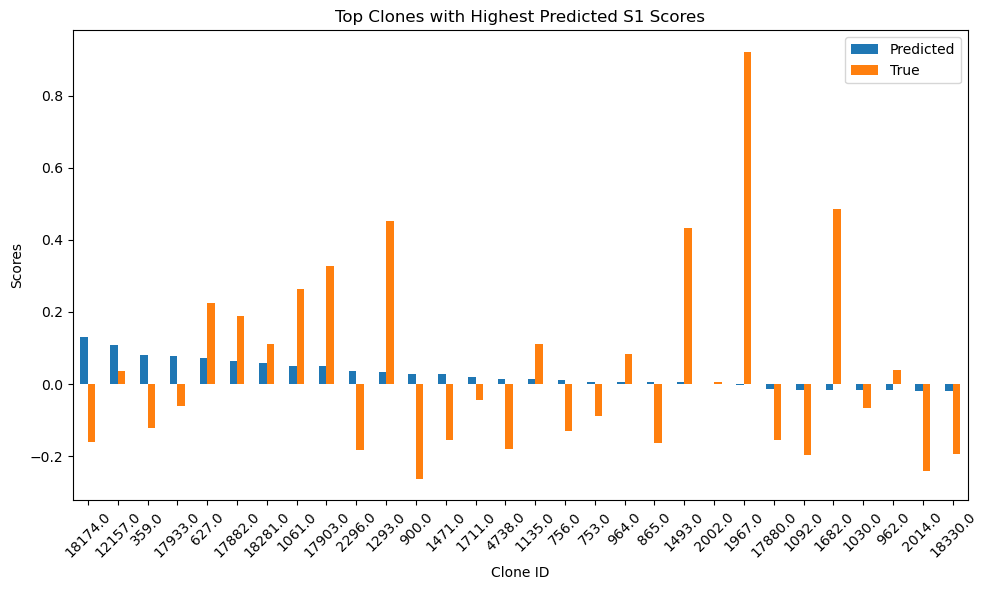

In [ ]:
# Bar plot for top clones
top_clones.plot(
    x="Clone_ID",
    y=["Mean_Predicted_S1_Score", "Mean_True_S1_Score"],
    kind="bar",
    figsize=(10, 6),
    title="Top Clones with Highest Predicted S1 Scores"
)
plt.ylabel("Scores")
plt.xlabel("Clone ID")
plt.xticks(rotation=45)
plt.legend(["Predicted", "True"])
plt.tight_layout()
plt.show()


In [ ]:
"""TODO 
import pandas as pd

# Korrelation zwischen den verschiedenen Zeitpunkten berechnen
correlation_matrix = results_df[['True_S1_Score', 'True_T1_Score', 'True_P1_Score']].corr()
print(correlation_matrix)"""


"TODO \nimport pandas as pd\n\n# Korrelation zwischen den verschiedenen Zeitpunkten berechnen\ncorrelation_matrix = results_df[['True_S1_Score', 'True_T1_Score', 'True_P1_Score']].corr()\nprint(correlation_matrix)"

In [ ]:
# investigating clone with top scores
top_clone_ids = top_clones["Clone_ID"].values
top_clone_metadata = adata.obs.loc[adata.obs["clone_id"].isin(top_clone_ids)]
print(top_clone_metadata)


                               is_cell high_confidence multi_chain  \
CCTTACGCAACTGCTA-1-initial-0-0    True            True       False   
GGGTTGCTCTTCAACT-1-initial-0-0    True            True       False   
GTTTCTAAGGATATAC-1-initial-0-0    True            True       False   
TATCAGGCATTGGTAC-1-initial-0-0    True            True       False   
TCGGGACAGGATGGTC-1-initial-0-0    True            True       False   
...                                ...             ...         ...   
GTGTTAGTCTAGAGTC-1-2-1            True            True       False   
GTTACAGTCGGAGCAA-1-2-1            True            True       False   
TAAGTGCCATATACGC-1-2-1            True            True       False   
TAGGCATTCAAGGCTT-1-2-1            True            True       False   
TAGTTGGGTCATACTG-1-2-1            True            True       False   

                               extra_chains IR_VJ_1_c_call IR_VJ_2_c_call  \
CCTTACGCAACTGCTA-1-initial-0-0           []           TRAC            NaN   
GGGTT

In [ ]:
# Compute MSE for top clones
top_clones_mse = mean_squared_error(
    top_clones["Mean_True_S1_Score"], top_clones["Mean_Predicted_S1_Score"]
)
print(f"Mean Squared Error for Top Clones (S1): {top_clones_mse:.4f}")

Mean Squared Error for Top Clones (S1): 0.0735


### Using only the top highest score per clone

In [ ]:
# Create a DataFrame with clone IDs, true scores, and predictions
results_df = pd.DataFrame({
    "Clone_ID": unique_clonotypes_aggregated[test_mask],  # Clonotypes in the test set
    "True_S1_Score": y_s1_test,  # True target values for S1
    "Predicted_S1_Score": model_s1.predict(X_s1_test),  # Predicted values for S1
    "True_T1_Score": y_t1_test,  # True target values for T1
    "Predicted_T1_Score": model_s1.predict(X_t1_test)  # Predicted values for T1
})


In [ ]:
# Select the highest predicted score for each clone
top_scores_per_clone = results_df.groupby("Clone_ID").agg(
    Max_True_S1_Score=("True_S1_Score", "max"),
    Max_Predicted_S1_Score=("Predicted_S1_Score", "max"),
    Max_True_T1_Score=("True_T1_Score", "max"),
    Max_Predicted_T1_Score=("Predicted_T1_Score", "max")
).reset_index()

# Sort by the highest predicted S1 scores
top_scores_per_clone = top_scores_per_clone.sort_values(by="Max_Predicted_S1_Score", ascending=False)


In [ ]:
# Select the top 10 clones
top_clones = top_scores_per_clone.head(10)
print(top_clones)


   Clone_ID  Max_True_S1_Score  Max_Predicted_S1_Score  Max_True_T1_Score  \
29  18174.0          -0.162282                0.130834          -0.047664   
9   12157.0           0.036488                0.107138           1.117963   
47    359.0          -0.121326                0.081074           0.560592   
26  17933.0          -0.061935                0.078250           0.188739   
55    627.0           0.225359                0.072620          -0.220331   
24  17882.0           0.188243                0.065188          -0.220140   
30  18281.0           0.110276                0.059674           0.245320   
2    1061.0           0.264781                0.050070           1.150848   
25  17903.0           0.328644                0.049412          -0.309307   
36   2296.0          -0.182169                0.036870          -0.132135   

    Max_Predicted_T1_Score  
29                0.130834  
9                 0.107138  
47                0.081074  
26                0.078250  
55     

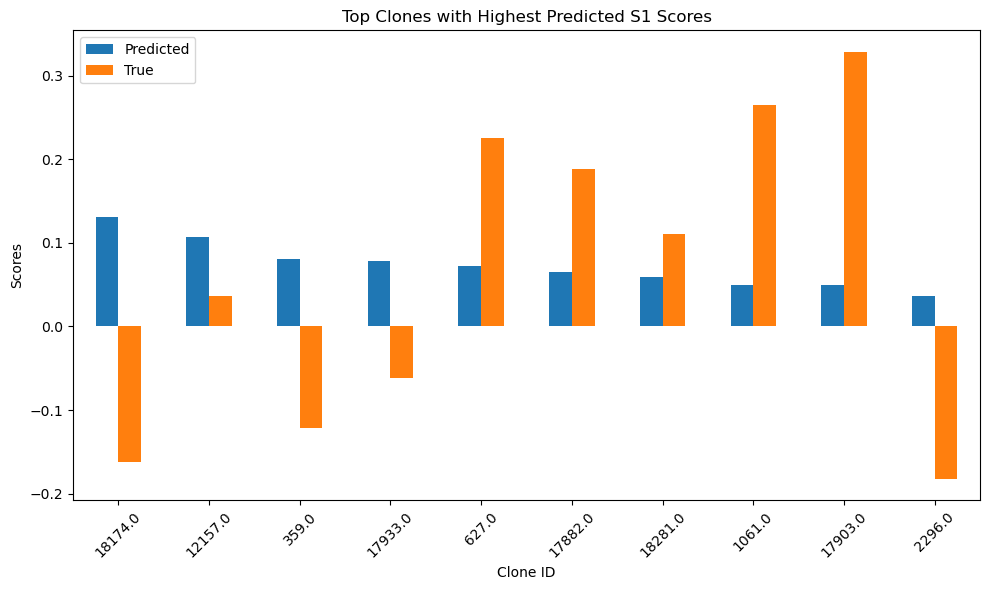

In [ ]:
import matplotlib.pyplot as plt

# Bar plot for top clones
top_clones.plot(
    x="Clone_ID",
    y=["Max_Predicted_S1_Score", "Max_True_S1_Score"],
    kind="bar",
    figsize=(10, 6),
    title="Top Clones with Highest Predicted S1 Scores"
)
plt.ylabel("Scores")
plt.xlabel("Clone ID")
plt.xticks(rotation=45)
plt.legend(["Predicted", "True"])
plt.tight_layout()
plt.show()


## Visualize Results

In [ ]:
clonotypes = adata.obs[['clone_id','time']].value_counts().reset_index().pivot(columns='time', index='clone_id', values='count')
clonotypes['sum']=clonotypes.sum(axis=1)
clonotypes = clonotypes.sort_values(by='sum', ascending=False)
clonotypes = clonotypes[(~clonotypes.isna()).sum(axis=1) > 2]

In [ ]:
clonotypes_ifn = clonotypes.iloc[:,0:-1].copy()
for clone in tqdm(clonotypes_ifn.index):
    for time in clonotypes_ifn.columns:
        clonotypes_ifn.loc[clone,time] = adata.obs.loc[(adata.obs.clone_id == clone) & (adata.obs.time == time),'IFN Response_score'].mean()

100%|██████████| 1763/1763 [00:02<00:00, 638.74it/s]


In [ ]:
clonotypes_ifn['sum'] = clonotypes['sum']

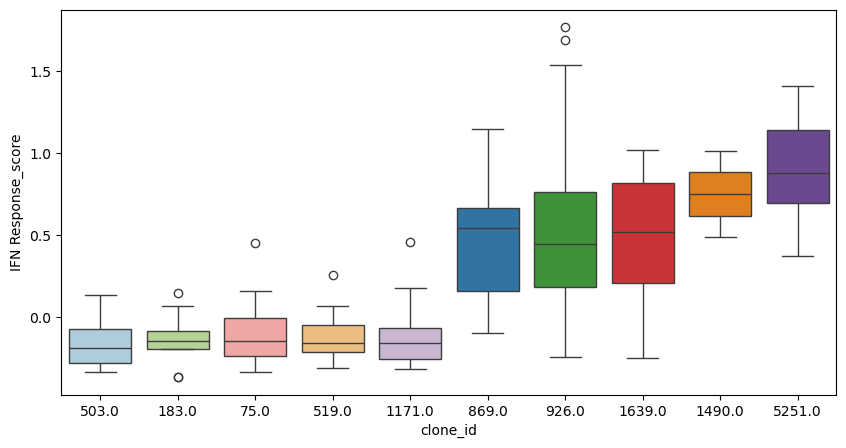

In [ ]:
clones = clonotypes_ifn[(~clonotypes_ifn.T1.isna()) & (clonotypes_ifn['sum'] > 50)].sort_values(by='T1').index
clones = clones[0:5].tolist() + clones[-6:-1].tolist()
dt = adata[adata.obs.clone_id.isin(clones) & (adata.obs.time == 'T1')].obs[['clone_id','IFN Response_score']]
dt.loc[:,['clone response']] = dt['clone_id'].map({clone: ('NR' if i < 5 else 'R') for i, clone in enumerate(clones)})

rcParams['figure.figsize'] = (10, 5)
sns.boxplot(data=dt, x="clone_id", y="IFN Response_score", hue="clone_id", palette='Paired', hue_order=np.array(clones)[[0,5,1,6,2,7,3,8,4,9]], order=clones)
rcParams['figure.figsize'] = (5, 4)

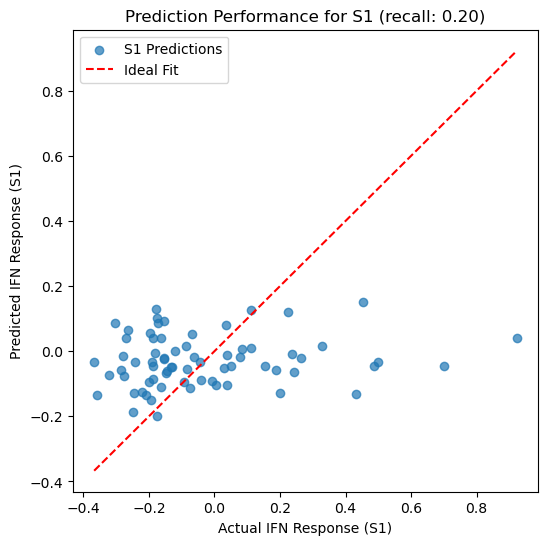

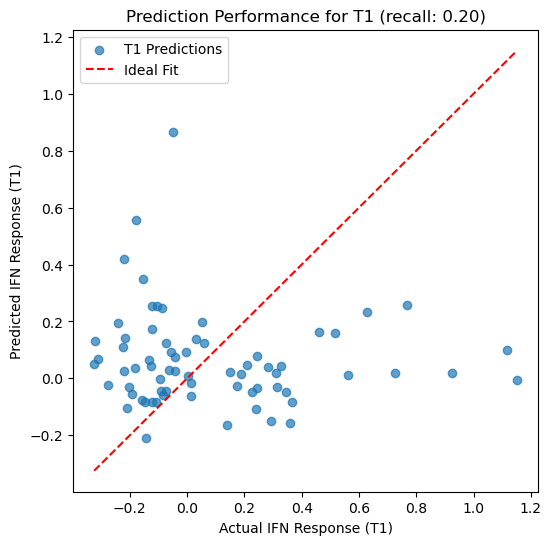

In [ ]:
import matplotlib.pyplot as plt

# Visualization for S1
plt.figure(figsize=(6, 6))
plt.scatter(y_s1_test, y_s1_pred, alpha=0.7, label="S1 Predictions")
plt.plot([y_s1_test.min(), y_s1_test.max()], [y_s1_test.min(), y_s1_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual IFN Response (S1)")
plt.ylabel("Predicted IFN Response (S1)")
plt.title(f"Prediction Performance for S1 (recall: {recall_ks1:.2f})")
plt.legend()
plt.show()

# Visualization for T1
plt.figure(figsize=(6, 6))
plt.scatter(y_t1_test, y_t1_pred, alpha=0.7, label="T1 Predictions")
plt.plot([y_t1_test.min(), y_t1_test.max()], [y_t1_test.min(), y_t1_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual IFN Response (T1)")
plt.ylabel("Predicted IFN Response (T1)")
plt.title(f"Prediction Performance for T1 (recall: {recall_kt1:.2f})")
plt.legend()
plt.show()


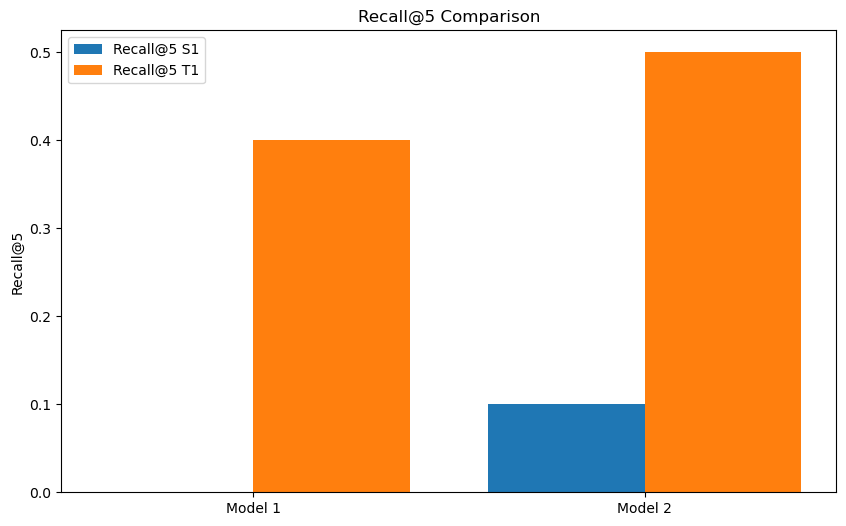

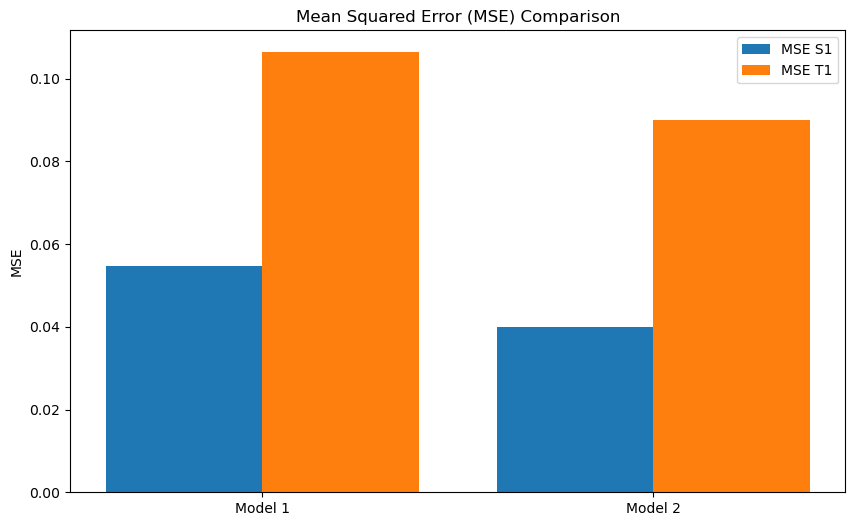

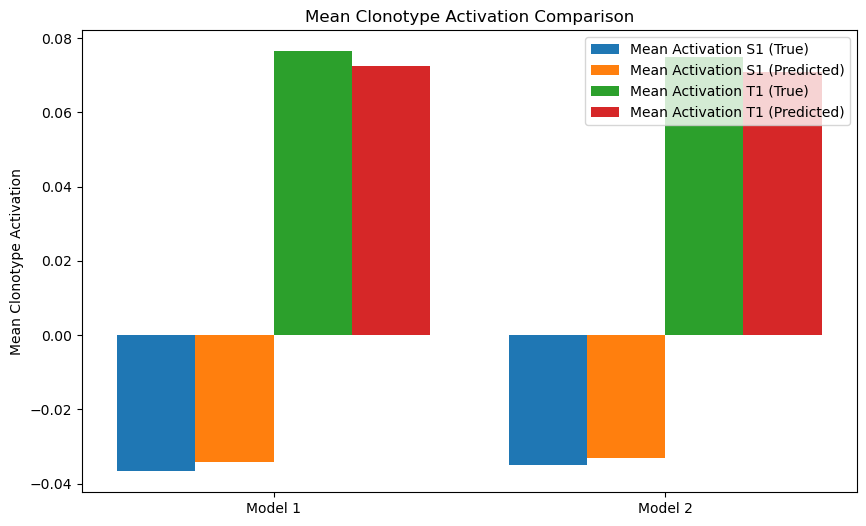

In [ ]:
# TODO jsut the concept, add values

# Example metrics for two models
models = ['Model 1', 'Model 2']  # Add more models as needed
recall_s1 = [0.00, 0.10]  # Replace with Recall@5 for S1 across models
recall_t1 = [0.40, 0.50]  # Replace with Recall@5 for T1 across models
mse_s1 = [0.0547, 0.0400]  # Replace with MSE for S1 across models
mse_t1 = [0.1064, 0.0900]  # Replace with MSE for T1 across models
mean_activation_s1 = [-0.0367, -0.0350]  # Replace with Mean Clonotype Activation (True) for S1
mean_activation_s1_pred = [-0.0342, -0.0330]  # Replace with Mean Clonotype Activation (Predicted) for S1
mean_activation_t1 = [0.0765, 0.0750]  # Replace with Mean Clonotype Activation (True) for T1
mean_activation_t1_pred = [0.0724, 0.0710]  # Replace with Mean Clonotype Activation (Predicted) for T1

x = np.arange(len(models))  # X locations for the groups

# Plot Recall@5
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, recall_s1, width=0.4, label='Recall@5 S1')
plt.bar(x + 0.2, recall_t1, width=0.4, label='Recall@5 T1')
plt.xticks(x, models)
plt.ylabel('Recall@5')
plt.title('Recall@5 Comparison')
plt.legend()
plt.show()

# Plot MSE
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, mse_s1, width=0.4, label='MSE S1')
plt.bar(x + 0.2, mse_t1, width=0.4, label='MSE T1')
plt.xticks(x, models)
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE) Comparison')
plt.legend()
plt.show()

# Plot Mean Clonotype Activation
plt.figure(figsize=(10, 6))
bar_width = 0.2
plt.bar(x - 0.3, mean_activation_s1, width=bar_width, label='Mean Activation S1 (True)')
plt.bar(x - 0.1, mean_activation_s1_pred, width=bar_width, label='Mean Activation S1 (Predicted)')
plt.bar(x + 0.1, mean_activation_t1, width=bar_width, label='Mean Activation T1 (True)')
plt.bar(x + 0.3, mean_activation_t1_pred, width=bar_width, label='Mean Activation T1 (Predicted)')
plt.xticks(x, models)
plt.ylabel('Mean Clonotype Activation')
plt.title('Mean Clonotype Activation Comparison')
plt.legend()
plt.show()


# Tune Parameters 

In [ ]:
params = {
    "n_estimators": 100, 
    "learning_rate": 0.1, 
    "max_depth": 3, 
    "random_state": 42,
    'device': 'mps'
}

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint

# Define parameter distribution
param_dist = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.7, 0.3),
    'max_features': ['sqrt', 'log2', None]
} # TODO do these parameters make sense?

# Initialize GradientBoostingRegressor
gbr = GradientBoostingRegressor()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

"""
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)
"""

# Fit the model
random_search.fit(X_s1_train, y_s1_train)

# Output the best parameters and the corresponding score
print("Best parameters:", random_search.best_params_)
print("Best score:", -random_search.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'learning_rate': 0.010518486277398677, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 57, 'subsample': 0.910590063177311}
Best score: 0.04249621891511715


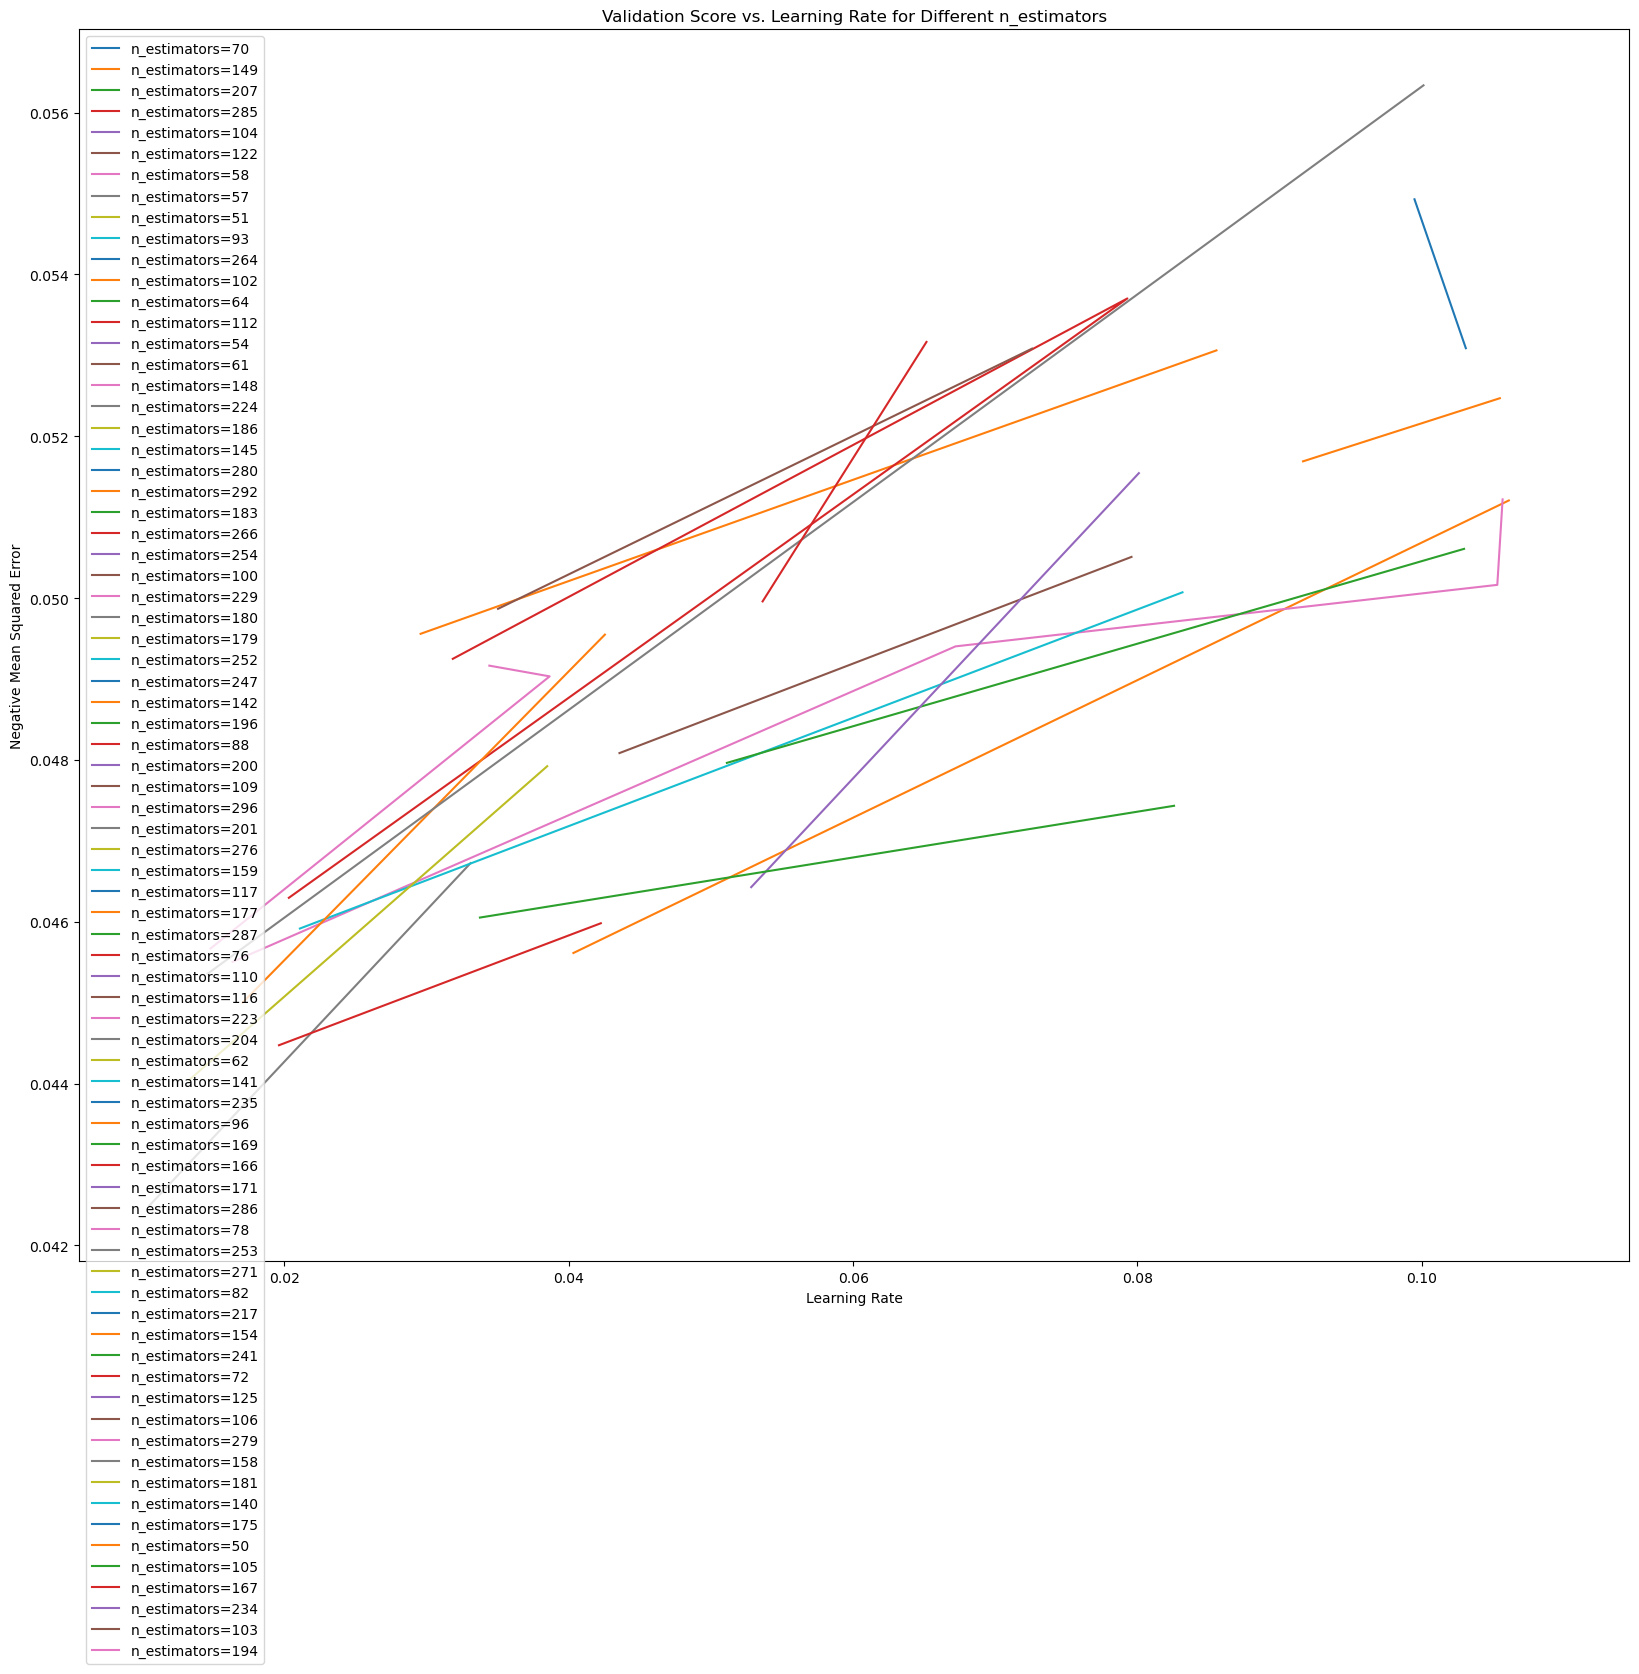

In [ ]:
#Plotting param tunign results
results = pd.DataFrame(random_search.cv_results_)

# Example: Visualizing validation score for different learning rates
plt.figure(figsize=(20, 16))
for n_estimators in results['param_n_estimators'].unique():
    subset = results[results['param_n_estimators'] == n_estimators]
    plt.plot(subset['param_learning_rate'], -subset['mean_test_score'], label=f'n_estimators={n_estimators}')

plt.xlabel('Learning Rate')
plt.ylabel('Negative Mean Squared Error')
plt.title('Validation Score vs. Learning Rate for Different n_estimators')
plt.legend()
plt.show()

TypeError: 'float' object is not iterable

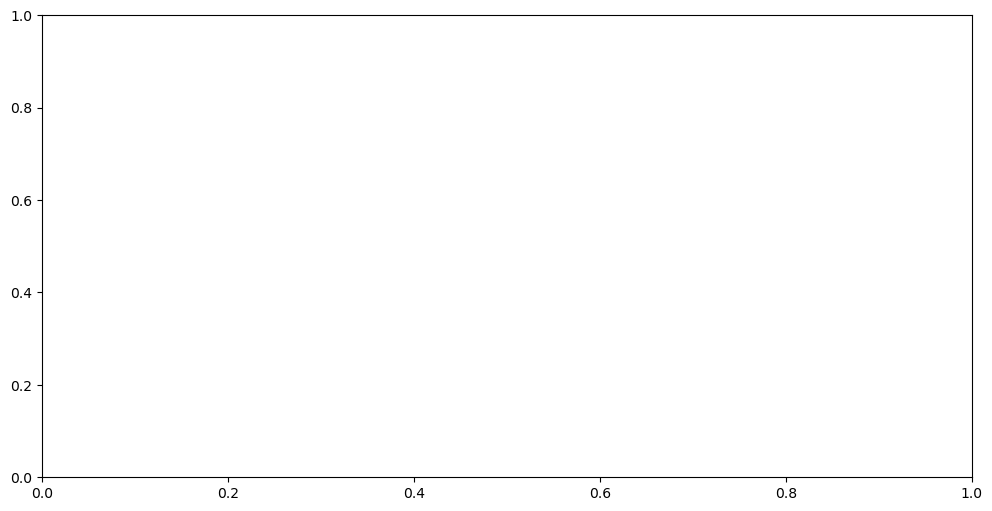

In [ ]:
# Create a single figure for all metrics, distinguishing between models
fig, ax = plt.subplots(figsize=(12, 6))

# Define colors for each model
model_colors = {
    "Baseline": "blue",
    "LinReg Timepoint": "green",
    "Grad Boosting Timepoint": "orange",
    "LinReg Donor": "purple",
    "Grad Boosting Donor": "red",
    "LinReg OT": "cyan",
    "Grad Boosting OT": "magenta"
}

# Prepare data for boxplot (transpose so each metric is a separate set)
data_values_transposed = list(map(list, zip(*data_values)))

# Positions for boxplots
positions = np.arange(len(metrics))

# Plot boxplots for each model
for i, (model, values) in enumerate(data.items()):
    values_transposed = list(map(list, zip(*values)))  # Transpose data for each metric
    for j, metric_values in enumerate(values_transposed):
        if not np.isnan(metric_values).all():  # Avoid NaN-only boxes
            ax.boxplot(metric_values, positions=[positions[j] + i * 0.1], widths=0.1,
                       patch_artist=True, boxprops=dict(facecolor=model_colors[model], alpha=0.6),
                       medianprops=dict(color="black"))

# Add labels and title
ax.set_xticks(positions)
ax.set_xticklabels(metrics, rotation=45, fontsize=10)
ax.set_ylabel("Values", fontsize=12)
ax.set_title("Comparison of Metrics Across Models", fontsize=14, fontweight="bold")

# Create a legend
legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=model)
                  for model, color in model_colors.items()]
ax.legend(handles=legend_handles, loc="upper right", fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

